### **Which frames have a water molecule in reactive position(close to the acid/base and oriented to the anomeric carbon)?**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

Write the path of the simulation and run just the cell of the simulation you want to analyze

In [3]:
dir_name = "/home/oriol/Oriol/coses_aliens/Irene_GH20/Water/"
top_file = "/home/oriol/Oriol/coses_aliens/Irene_GH20/Water/lnbase-s2-oxi.parm7"
file = dir_name + "prod_oxi_free_r3_50ns.nc"

This cell loads just the information of the trajectory, not all the coordinates

In [4]:
traj = md.formats.NetCDFTrajectoryFile(file) # .nc format
top = md.load_prmtop(top_file)

In [5]:
print("Frames =",traj.n_frames)

Frames = 2500


Select the atoms to compute the distances

In [6]:
acid_base = top.select('resid 281 and sidechain and type O') #0-based index, residue 156 [E173]
c_anom = top.select('index 9727')                            #Anomeric carbon
H_wat = top.select('water and type H')                       #Both Hydrogen atoms of each water molecule
O_wat = top.select('water and type O')                       #Oxygen atoms of each water molecule

CPU times: user 215 ms, sys: 15 µs, total: 215 ms
Wall time: 214 ms


In [24]:
print("Number of water molecules =",np.shape(O_wat)[0])
print("Index of oxygens of acid/base residue:",acid_base[:])
print("Index of anomeric carbon:",c_anom[:])

Number of water molecules = 33884
Index of oxygens of acid/base residue: [4330 4331]
Index of anomeric carbon: [9727]


### 1.To obtain oriented water molecules

Cutoff[Å] to consider "close" water:

In [31]:
#Modify here the desired cutoff
O_cutoff = 3.8
H_cutoff = 2.2

O_cutoff /= 10  #MDtraj module uses nanometers
H_cutoff /= 10

In [32]:
%%time

pair_array_H = np.array(list(itertools.product(H_wat, acid_base))) #Pairs of all possible combinations between H atoms indexes and O indexes of Acid-Base
pair_array_O = np.array(list(itertools.product(O_wat, c_anom)))  
pair_array_c_H = np.array(list(itertools.product(H_wat, c_anom))) 

traj.seek(0, whence=0) 
close_wat = []  
oriented_wat = [] 
dist_H = np.empty((0,pair_array_H.shape[0]))
dist_O = np.empty((0,pair_array_O.shape[0])) 
dist_c_H = np.empty((0,pair_array_c_H.shape[0])) 

index_time = np.zeros((100,2))   #max allowed waters in one frame (100)
residence_count = np.zeros((1,2)) 
max_residence = 0

for i in range(traj.n_frames):      
    index_list=[]                   
    frame = traj.read_as_traj(top,n_frames=1)   
    dist_H = md.compute_distances(frame, pair_array_H)[0] 
    dist_O = md.compute_distances(frame, pair_array_O)[0] 
    dist_c_H = md.compute_distances(frame, pair_array_c_H)[0] 
    count = 0
    oriented_count = 0
    for j in range(dist_O.shape[0]): 
        if dist_O[j]>O_cutoff: 
            continue 
        
        for k in range(4):          
            if dist_H[4*j+k]<H_cutoff: 
                count+=1 
                break 
        else: 
            continue
        index_list.append(O_wat[j]) 
    
        if dist_c_H[2*j]<dist_O[j] or dist_c_H[2*j+1]<dist_O[j]: 
            continue 
        oriented_count += 1 
    
    for m in range(index_time.shape[0]): 
        if index_time[m,0] in index_list: 
            index_time[m,1] += 1
            index_list.remove(index_time[m,0]) 
            if index_time[m,1] > max_residence: 
                max_residence = index_time[m,1] 
                max_index_residence = index_time[m,0] 
        else: 
            if index_time[m,0] != -1: 
                residence_count[0,0] += 1
                residence_count[0,1] += index_time[m,1] 
                index_time[m,1] = 0 
                index_time[m,0] = -1 
            
    for n in index_list:
        p = 0 
        while index_time[p,0] != -1:
            p += 1 
        index_time[p,0] = n 
        index_time[p,1] = 1 
    
    close_wat.append([frame.time[0],count])
    oriented_wat.append([frame.time[0],oriented_count,traj.tell()])
close_waters=np.asarray(close_wat)
oriented_waters=np.asarray(oriented_wat)
residence_time = residence_count[0,1]/residence_count[0,0]

CPU times: user 2min 15s, sys: 160 ms, total: 2min 15s
Wall time: 2min 15s


In [33]:
#Mean of oriented water molecules over time
mean_ori_wat = np.sum(oriented_waters[:,1])/oriented_waters[:,1].shape[0]
print("Mean of oriented water molecules over time =", mean_ori_wat)

Mean of oriented water molecules over time = 0.3136


In [34]:
frame_ps = 20 #Time between frames, depends on your simulation: 0,002ps/1step (timestep) * 10000steps/1frame (frame printing stride) = 20 ps per frame
print("residence time = {} ps ".format(round(residence_time,3)))
print("mean residence time = {} ps  ".format(round(residence_time*frame_ps,3)))
print("maximum residence time = {} ps".format(max_residence*frame_ps))
print("frame = {}ps".format(frame_ps))

residence time = 1.512 ps 
mean residence time = 30.247 ps  
maximum residence time = 180.0 ps
frame = 20ps


In [35]:
#Mean of close water molecules over time
mean_wat = np.sum(close_waters[:,1])/close_waters[:,1].shape[0]
print("Mean of close water molecules over time =", mean_wat)

Mean of close water molecules over time = 0.7856


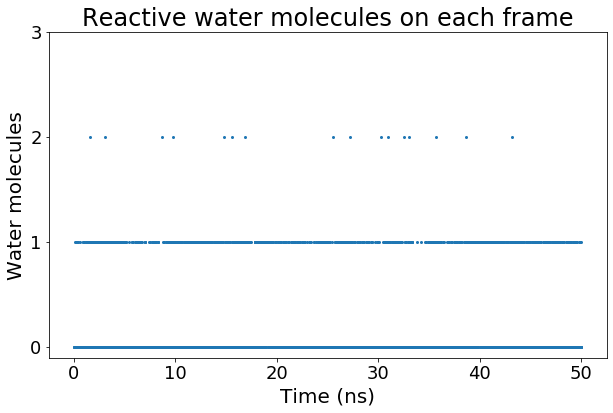

In [36]:
fig1 = plt.figure(figsize=(10,6))
plt.scatter(oriented_waters[:,0]/1000,oriented_waters[:,1], s=4)
# plt.scatter(oriented_waters[:,2],oriented_waters[:,1], s=0.5)
# plt.text(120,1.75,"Mean residence time:      {}ps".format(round(residence_time*frame_ps,1)),fontsize=18)
# plt.text(120,1.625,"Mean oriented molecules: {}".format(round(mean_ori_wat,3)),fontsize=18)
# plt.text(120,1.5,"Mean close molecules:      {}".format(round(mean_wat,3)),fontsize=18)
# plt.xlabel("Frame", fontsize=16)
plt.xlabel("Time (ns)", fontsize=20)
plt.ylabel("Water molecules", fontsize=20)
plt.title("Reactive water molecules on each frame", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks([0,1,2,3],fontsize=18)  #Modify the yticks if there is more than 2 close waters in your result
# plt.savefig("Oriented_waters_{}A-{}A.png".format(O_cutoff,H_cutoff))
plt.show()

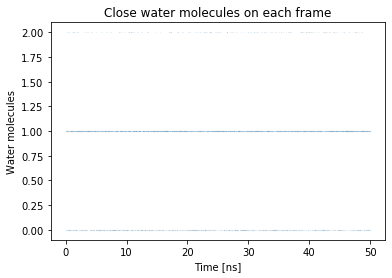

In [37]:
plt.scatter(close_waters[:,0]/1000,close_waters[:,1], s=0.001)
plt.xlabel("Time [ns]")
plt.ylabel("Water molecules")
plt.title("Close water molecules on each frame")
#plt.savefig("Close_waters.png")
plt.show()

Calculates the average of close waters in a window of X frames

In [38]:
bin_size = 200 #number of frames in the window

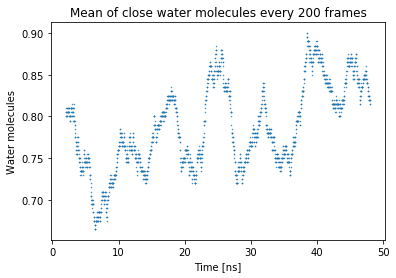

In [39]:
mean_list = []
for i in range(close_waters[:,1].shape[0] - bin_size):
    mean_list.append(np.sum(close_waters[i:bin_size+i,1])/bin_size)
plt.scatter(close_waters[int(bin_size/2):-int(bin_size/2),0]/1000,mean_list, s=0.2)
# plt.ylim(0,1.75)
plt.xlabel("Time [ns]")
plt.ylabel("Water molecules")
plt.title("Mean of close water molecules every {} frames".format(bin_size))
# plt.savefig("Mean_close_waters3_{}.png".format(bin_size))
plt.show()

### 2.To obtain only close waters
This part doesn't calculate if the molecules are oriented, but it's usually a bit faster

In [ ]:
%%time

traj.seek(0, whence=0) #Go to the first frame
O_cutoff = 0.6 
H_cutoff = 0.35
close_wat = []
dist_H = np.empty((0,pair_array_H.shape[0]))
dist_O = np.empty((0,pair_array_O.shape[0]))

index_time = np.zeros((10,2))   #max allowed waters
residence_count = np.zeros((1,2))
max_residence = 0

for i in range(traj.n_frames):       #loop frames
    index_list=[]
    frame = traj.read_as_traj(top,n_frames=1)  #Load coordinates of current frame
    dist_H = md.compute_distances(frame, pair_array_H)[0]
    dist_O = md.compute_distances(frame, pair_array_O)[0]
    
    count = 0
    for j in range(dist_O.shape[0]): #loop waters
        if dist_O[j]>O_cutoff:
            continue
        for k in range(4):           #loop Hydrogens
            if dist_H[4*j+k]<H_cutoff:
                count+=1                  
                break
        else:      
            continue      #If there is no close water, jump to the new frame
        index_list.append(O_wat[j])  #Write down in a list the oxygen index that is 
    
    #To calculate the residence time
    for m in range(index_time.shape[0]):
        if index_time[m,0] in index_list:        
            index_time[m,1] += 1
            index_list.remove(index_time[m,0])
            if index_time[m,1] > max_residence:
                max_residence = index_time[m,1]
                max_index_residence = index_time[m,0]
        else:
            if index_time[m,0] != -1:
                residence_count[0,0] += 1
                residence_count[0,1] += index_time[m,1]
                index_time[m,1] = 0
                index_time[m,0] = -1
            
            
    for n in index_list:
        p = 0
        while index_time[p,0] != -1:
            p += 1
        index_time[p,0] = n
        index_time[p,1] = 1            
    
    close_wat.append([frame.time[0],count])
close_waters=np.asarray(close_wat)
residence_time = residence_count[0,1]/residence_count[0,0]

In [ ]:
frame_ps = 20 #Time between frames, depends on your simulation: 0,002ps/1step (timestep) * 10000steps/1frame (frame printing stride) = 20 ps per frame
print("residence time = {} ps ".format(round(residence_time,3)))
print("mean residence time = {} ps  ".format(round(residence_time*frame_ps,3)))
print("maximum residence time = {} ps".format(max_residence*frame_ps))
print("frame = {}ps".format(frame_ps))

In [ ]:
figx = plt.figure(figsize=(10,6))
plt.scatter(close_waters[:,0]/1000,close_waters[:,1], s=4)
# plt.scatter(oriented_waters[:,2],oriented_waters[:,1], s=0.5)
# plt.text(120,1.75,"Mean residence time:      {}ps".format(round(residence_time*frame_ps,1)),fontsize=18)
# plt.text(120,1.625,"Mean oriented molecules: {}".format(round(mean_ori_wat,3)),fontsize=18)
# plt.text(120,1.5,"Mean close molecules:      {}".format(round(mean_wat,3)),fontsize=18)
# plt.xlabel("Frame", fontsize=16)
plt.xlabel("Time (ns)", fontsize=20)
plt.ylabel("Water molecules", fontsize=20)
plt.title("Close water molecules on each frame", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks([0,1,2,3,4,5],fontsize=18)  #Modify the yticks if there is more than 2 close waters in your result
# plt.savefig("Close_waters_{}A-{}A.png".format(O_cutoff,H_cutoff))
plt.show()